In [1]:
%cd ..

/home/sasha/effective-inference


## Import libs

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch

#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict
from utils.prepare_dataset import load_datasets, cut_datasets

## Define hyperparams

In [3]:
# Define datasets
#['mrpc', 'sst2', 'cola', 'rte', 'qnli']
glue_classification = {'mrpc': ['sentence1', 'sentence2']} #, 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model.to(device)
DEBUG_FLAG = True
CUT_SIZE = None if not DEBUG_FLAG else 500

## Load datasets

In [4]:
glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), CUT_SIZE)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

## Collect dataset for layers and heads

In [5]:
import numpy as np
import json
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [6]:
def get_dataset_for_regression(prob_of_take=0.13, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    length = len(glue_datasets['mrpc']['train']) if not CUT_SIZE else CUT_SIZE
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        encoded_inputs = tokenizer.encode(
                            ex['sentence1'],
                            ex['sentence2'],
                            truncation=True,
                            return_tensors='pt'
                        )
        special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
        with h5py.File(f'notebooks/mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:

            current_hidden_states = f['current_hidden_states'][()]
            next_hidden_states = f['next_hidden_states'][()]
            attentions = f['attentions'][()]

            len_of_seq = attentions.shape[0]
            for from_ in range(len_of_seq):
                for to_ in range(len_of_seq):
                    if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.5:
                        feature_vector = []
                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)


                        feature_vector.append(from_) # from_ pos
                        feature_vector.append(to_) # to_ pos

                        is_from_special_token = int(from_ in special_symbols)
                        is_to_special_token = int(to_ in special_symbols)
                        feature_vector.append(is_from_special_token)
                        feature_vector.append(is_to_special_token)

                        feature_vector.append(len_of_seq)
                        feature_vector.append(1/len_of_seq)
                        feature_vector.append(from_/len_of_seq)
                        feature_vector.append(to_/len_of_seq)
                        feature_vector.append(len_of_seq - from_)
                        feature_vector.append(len_of_seq - to_)
                        feature_vector += list(current_hidden_states[to_])


                        if ex_idx < length*0.85:
                            X_train.append(feature_vector)
                            y_train.append(attentions[from_, to_])
                        else:
                            X_test.append(feature_vector)
                            y_test.append(attentions[from_, to_])
    return X_train, y_train, X_test, y_test

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean

def learn(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, feature_names, num_examples = 1):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) # .reshape(-1, 1)
    y_test_scaled = y_scaler(y_test) # .reshape(-1, 1)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(y_test_scaled, label='Test scaled distribution')
    plt.title('Target distribution')
    plt.plot()

    print('Y train mean:', np.mean(y_train_scaled))
    print('Y test mean:', np.mean(y_test_scaled))

    print('Mean cross val R2:', np.mean(cross_val_score(model, X_train, y_train_scaled, cv=5, scoring='r2')))

    model.fit(X_train, y_train_scaled)
    preds_scaled = model.predict(X_test)
    preds = reverse_scaler(preds_scaled)

    r2_score_test = r2_score(y_test, preds)
    print('Test R2:', r2_score_test)
    print('\nPredictions:')
    samples = np.random.choice(len(X_test), size=num_examples, replace=False)
    for i in samples:
        print(f'Pred = {preds_scaled[i]} / {preds[i]} and target = {y_test_scaled[i]} / {y_test[i]}')

    


    # # Plot the distribution of y_train_scaled
    # sns.displot(y_train_scaled, label='Y train distribution')
    #  # Plot the distribution of y_test_scaled
    # sns.displot(y_test_scaled,label='Y test distribution')


    # Scatter plot of predictions vs. actual values
    plt.subplot(1, 3, 2)
    ax[1].scatter(y_test, preds)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Predictions')
    ax[1].set_title('Predictions vs. Actual Values')

    feature_importance = [abs(el) for el in model[1].coef_]
    most_important_features = np.argsort(feature_importance)[:14]
    fnames = np.array(feature_names)[most_important_features]
    fimport = np.array(feature_importance)[most_important_features]
    #print(fnames, fimport)
    plt.subplot(1, 3, 3)
    ax[2].bar(fnames, fimport)
    ax[2].set_xlabel('Features')
    ax[2].set_ylabel('Importance')
    ax[2].set_title('Feature Importance')
    ax[2].set_xticks(fnames)
    ax[2].set_xticklabels(fnames, rotation=90)

    plt.tight_layout()
    plt.show()


    return model

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('lin', Ridge())])

In [9]:
id_scaler = lambda x: [el for el in x]
log_scaler = lambda x: np.log(x * 1000 + 1)
log_reverse = lambda x: (np.exp(x) - 1) / 1000

## Layer 0

In [40]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=0, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

500it [01:18,  6.39it/s]


((166153, 778), (28978, 778))

### WITH SPECIAL SYMBOLS

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.3236805810659322
Test R2: 0.34878642585997666

Predictions:
Pred = 0.02834711154877024 / 0.02834711154877024 and target = 0.021885214373469353 / 0.021885214373469353


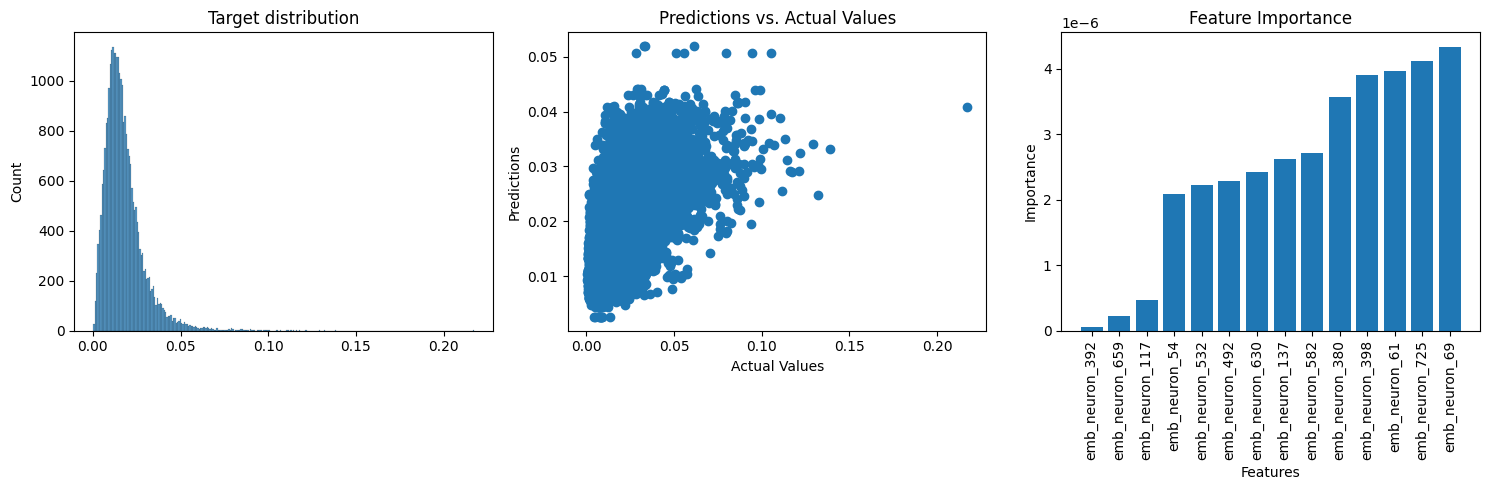

Success


In [41]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.32374344213243333
Test R2: 0.34882166521121005

Predictions:
Pred = 0.026012173739917835 / 0.026012173739917835 and target = 0.03511328622698784 / 0.03511328622698784


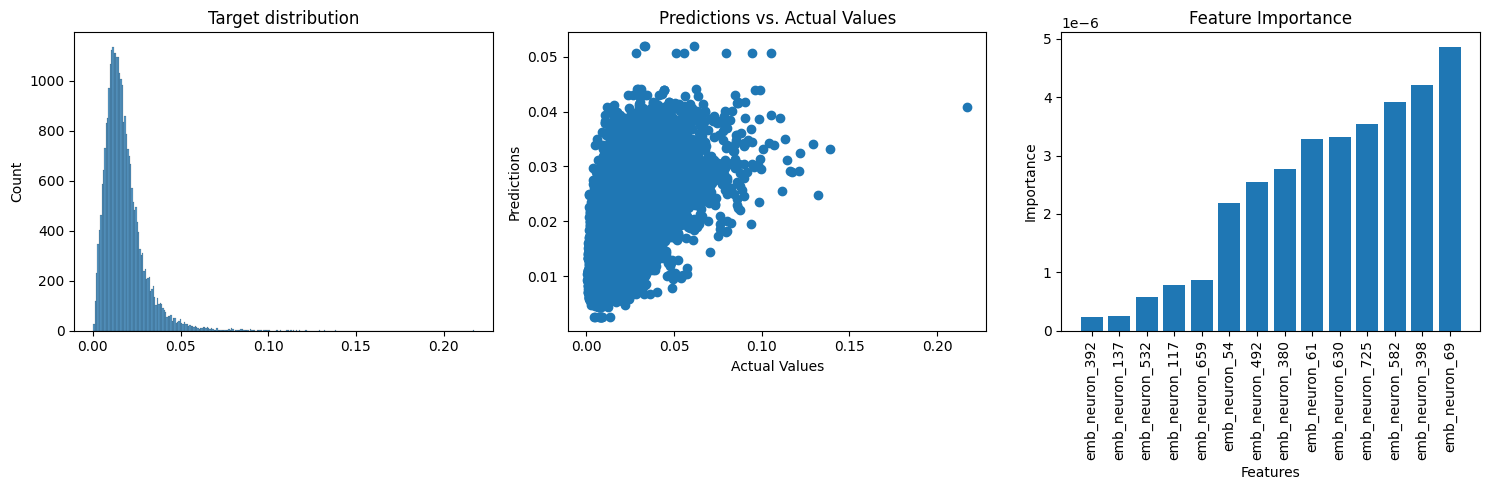

Success


In [42]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS AND EMB

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.14209271830681497
Test R2: 0.17066236112133648

Predictions:
Pred = 0.01350960678781726 / 0.01350960678781726 and target = 0.004030893091112375 / 0.004030893091112375


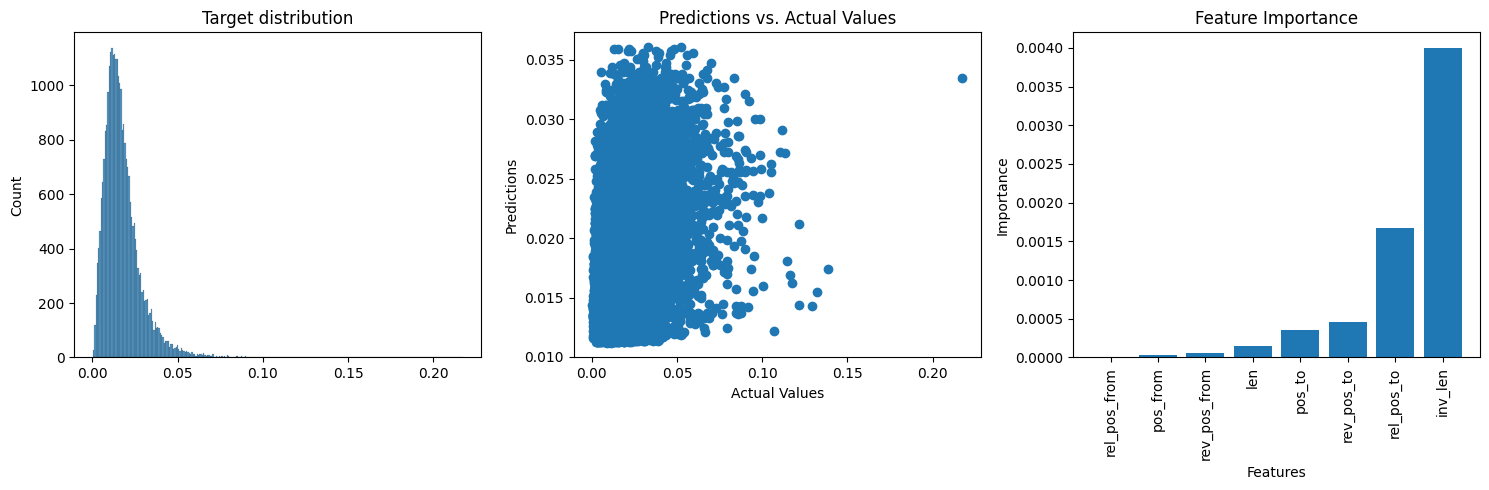

Success


In [43]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO EMB

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.15557578165288416
Test R2: 0.1866857471478619

Predictions:
Pred = 0.023447968091883833 / 0.023447968091883833 and target = 0.014355790801346302 / 0.014355790801346302


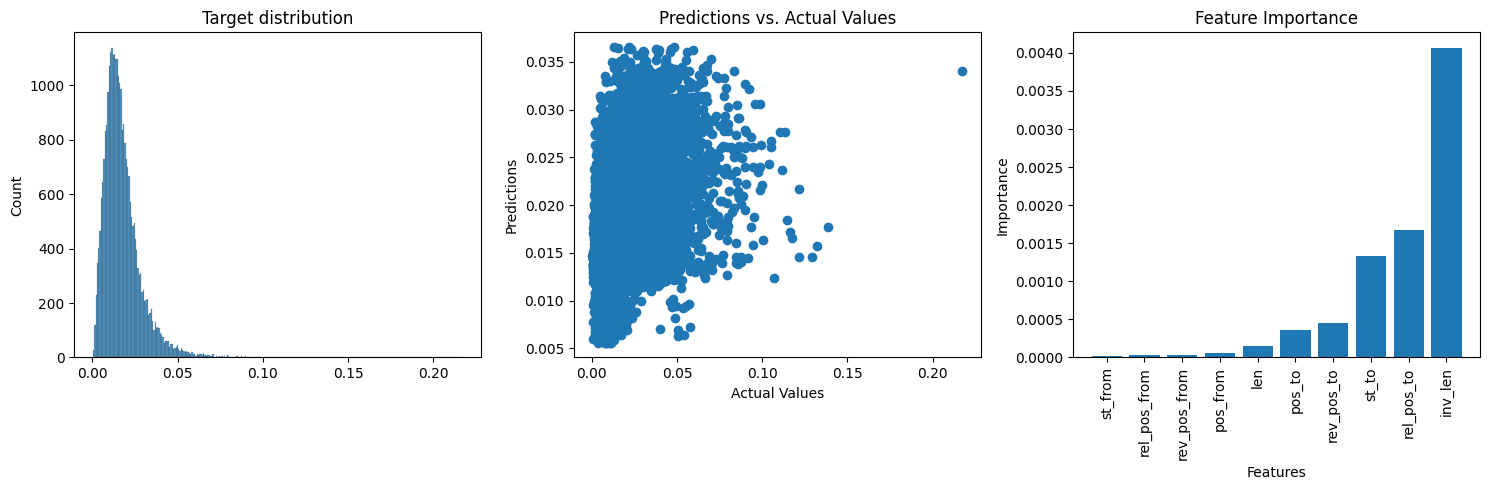

Success


In [44]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ADD POLYNOMIAL

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.15077065368345172
Test R2: 0.18208135316954144

Predictions:
Pred = 0.01589105783109303 / 0.01589105783109303 and target = 0.013280908577144146 / 0.013280908577144146


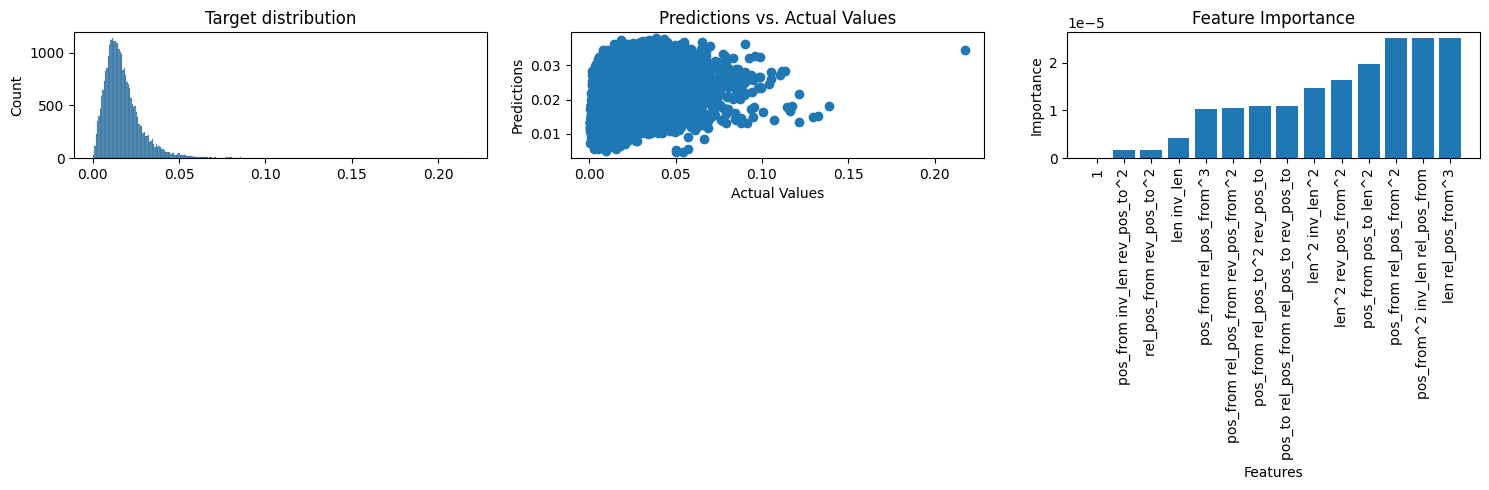

Success


In [45]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

### ADD ALL TOGETHER

Y train mean: 0.017719634
Y test mean: 0.017675979
Mean cross val R2: 0.32576226727890967
Test R2: 0.35252738544326556

Predictions:
Pred = 0.027766863855978624 / 0.027766863855978624 and target = 0.05367611348628998 / 0.05367611348628998


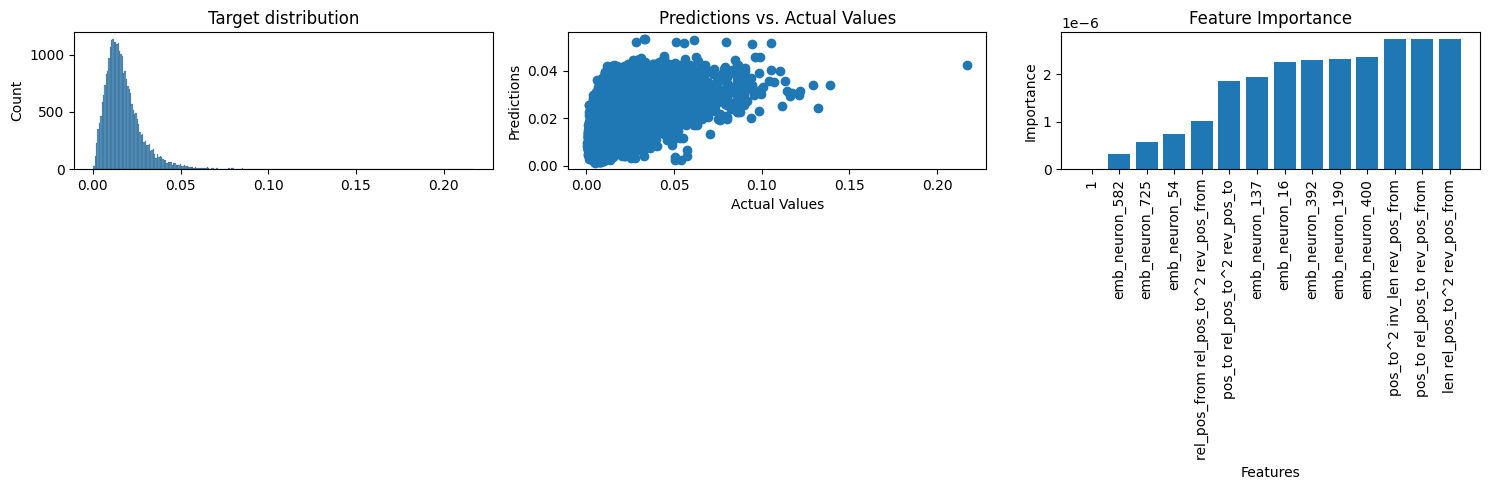

Success


In [46]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

## Layer 3

In [18]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=3, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

500it [01:19,  6.25it/s]


((166778, 778), (29301, 778))

### WITH SPECIAL SYMBOLS

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.066970531968788
Test R2: 0.07255578945842478

Predictions:
Pred = 0.005979193715118786 / 0.005979193715118786 and target = 8.080926636466756e-05 / 8.080926636466756e-05


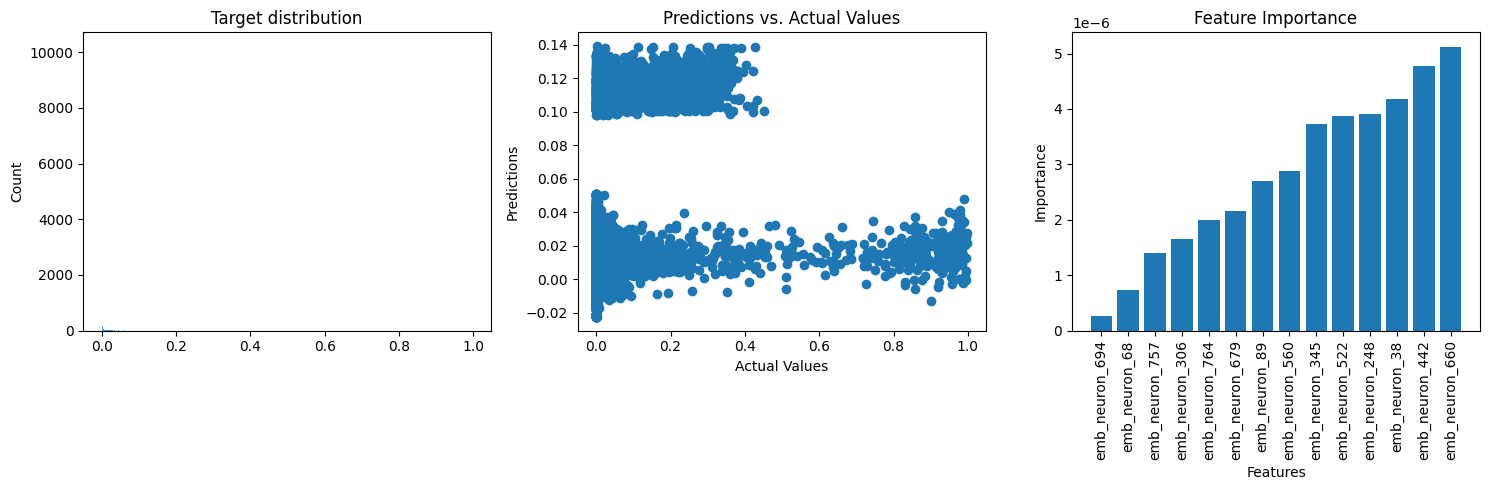

Success


In [19]:

feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.06647785122744201
Test R2: 0.07207373031758335

Predictions:
Pred = 0.017731741824192977 / 0.017731741824192977 and target = 0.000355610711267218 / 0.000355610711267218


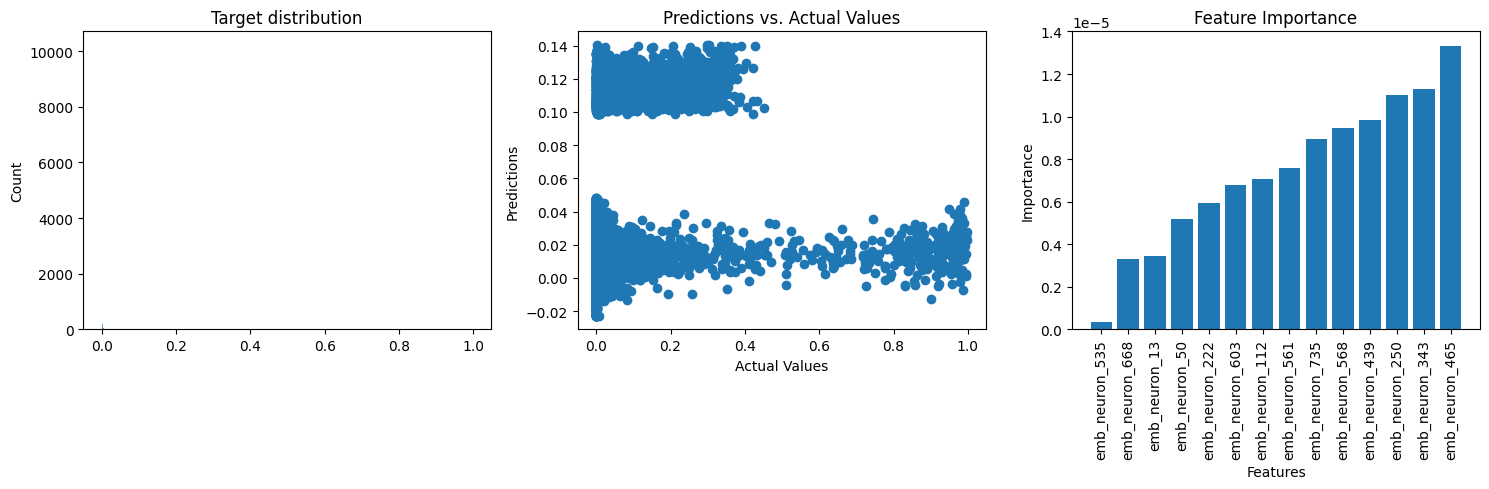

Success


In [20]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS AND EMB

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.0022097965967003753
Test R2: 0.0029074017796204554

Predictions:
Pred = 0.02680316401146468 / 0.02680316401146468 and target = 0.0017097040545195341 / 0.0017097040545195341


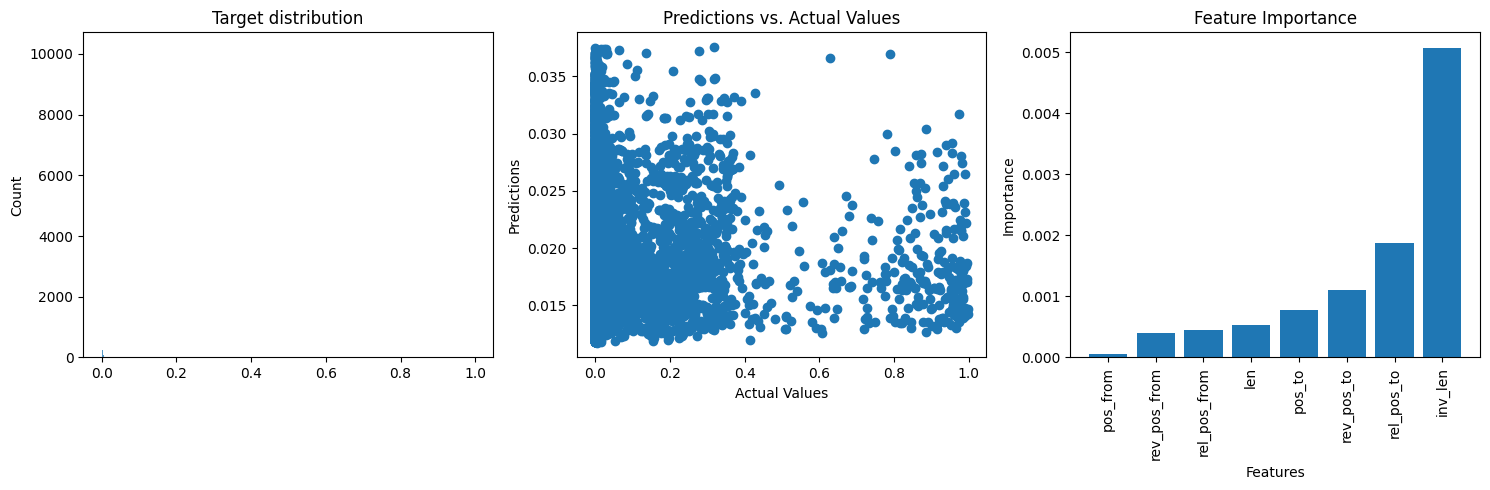

Success


In [21]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO EMB

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.06792251634431876
Test R2: 0.07261335848356798

Predictions:
Pred = 0.009004425660507246 / 0.009004425660507246 and target = 0.05449993163347244 / 0.05449993163347244


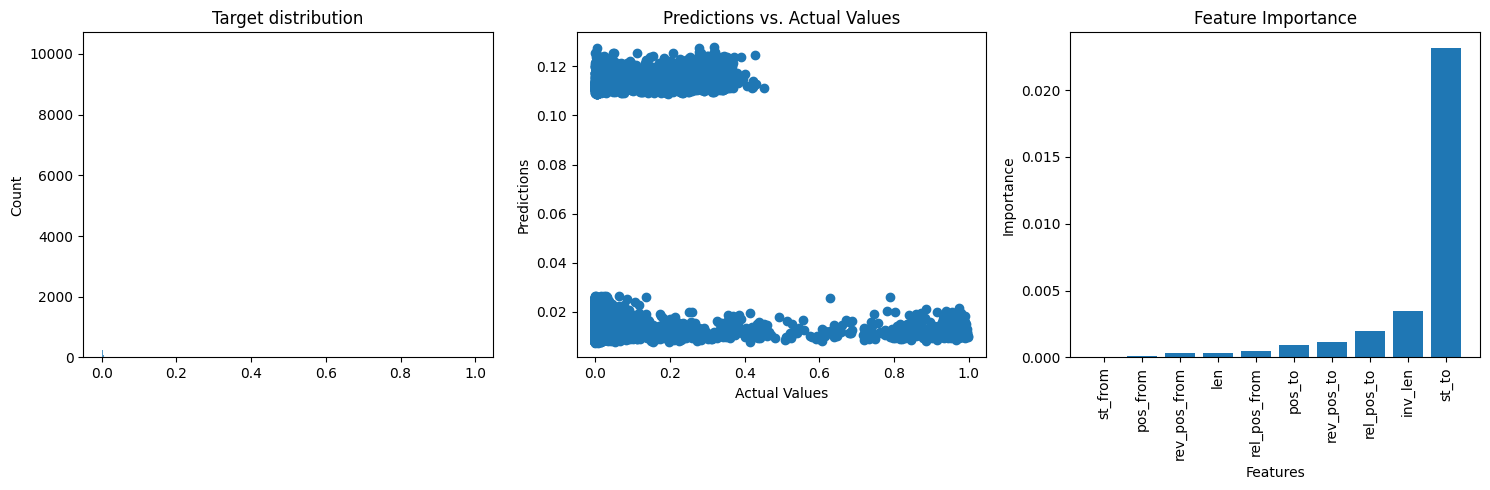

Success


In [22]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ADD POLYNOMIAL

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.0292475192750943
Test R2: 0.030617793634431845

Predictions:
Pred = 0.014610610674245253 / 0.014610610674245253 and target = 0.003540490521118045 / 0.003540490521118045


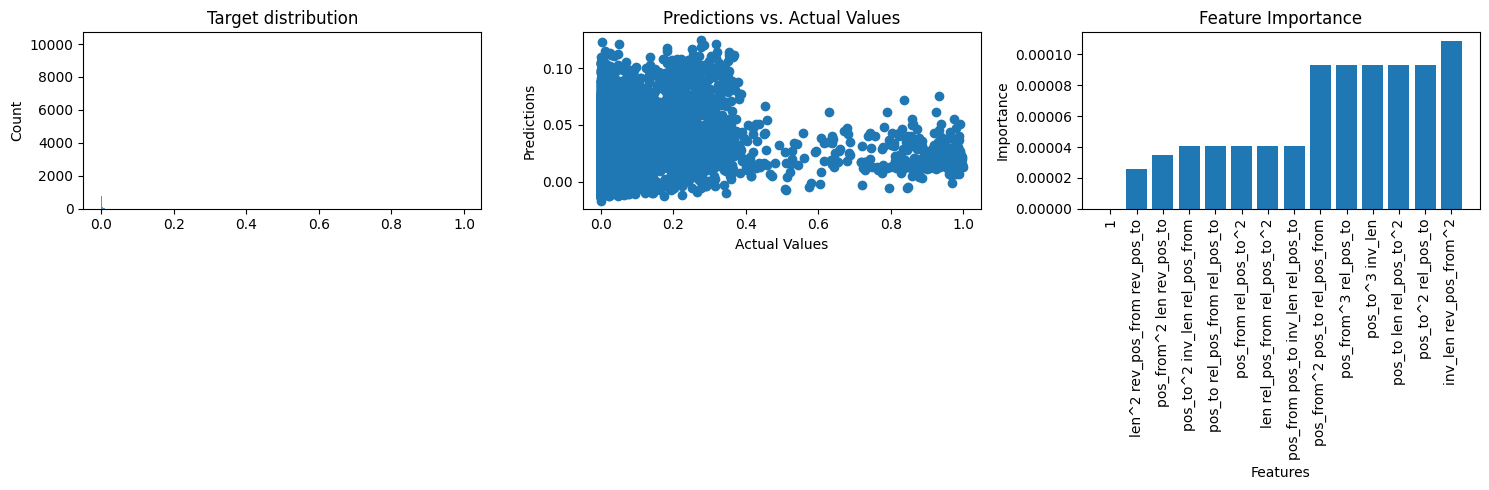

Success


In [23]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

### ADD ALL TOGETHER

Y train mean: 0.017775785
Y test mean: 0.0185853
Mean cross val R2: 0.0734025117354042
Test R2: 0.08092933684395831

Predictions:
Pred = 0.04512372397606977 / 0.04512372397606977 and target = 0.0062147481366992 / 0.0062147481366992


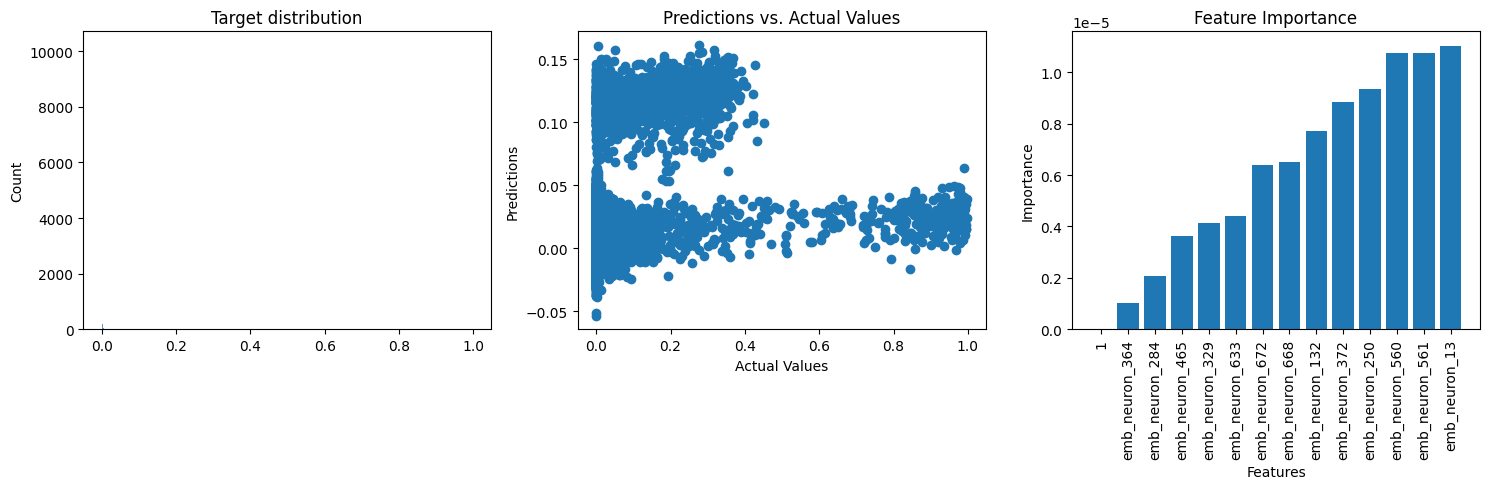

Success


In [24]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

## Layer 7

In [25]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=7, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

500it [01:19,  6.27it/s]


((165907, 778), (29012, 778))

### WITH SPECIAL SYMBOLS

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.3636129776049907
Test R2: 0.3727536819846984

Predictions:
Pred = 0.16209216940662155 / 0.16209216940662155 and target = 0.07159797102212906 / 0.07159797102212906


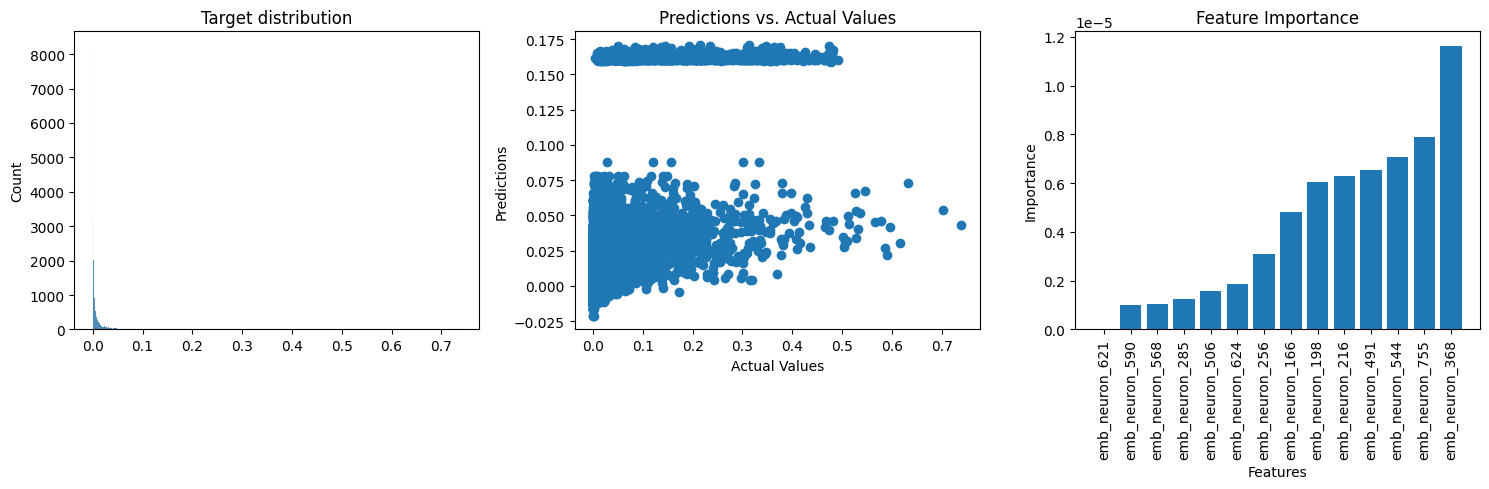

Success


In [26]:

feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.3632632341785095
Test R2: 0.3725737346040209

Predictions:
Pred = 0.02072248845438288 / 0.02072248845438288 and target = 0.0002744971716310829 / 0.0002744971716310829


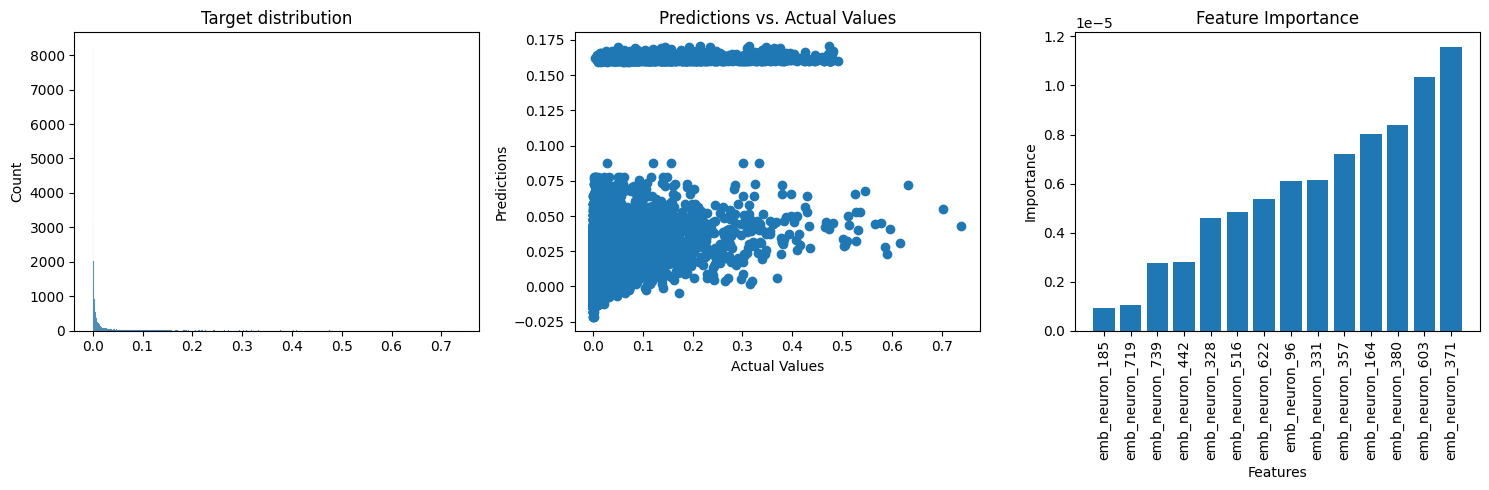

Success


In [27]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS AND EMB

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.009760112415335542
Test R2: 0.012525232695042354

Predictions:
Pred = 0.01341631006825664 / 0.01341631006825664 and target = 0.0077362568117678165 / 0.0077362568117678165


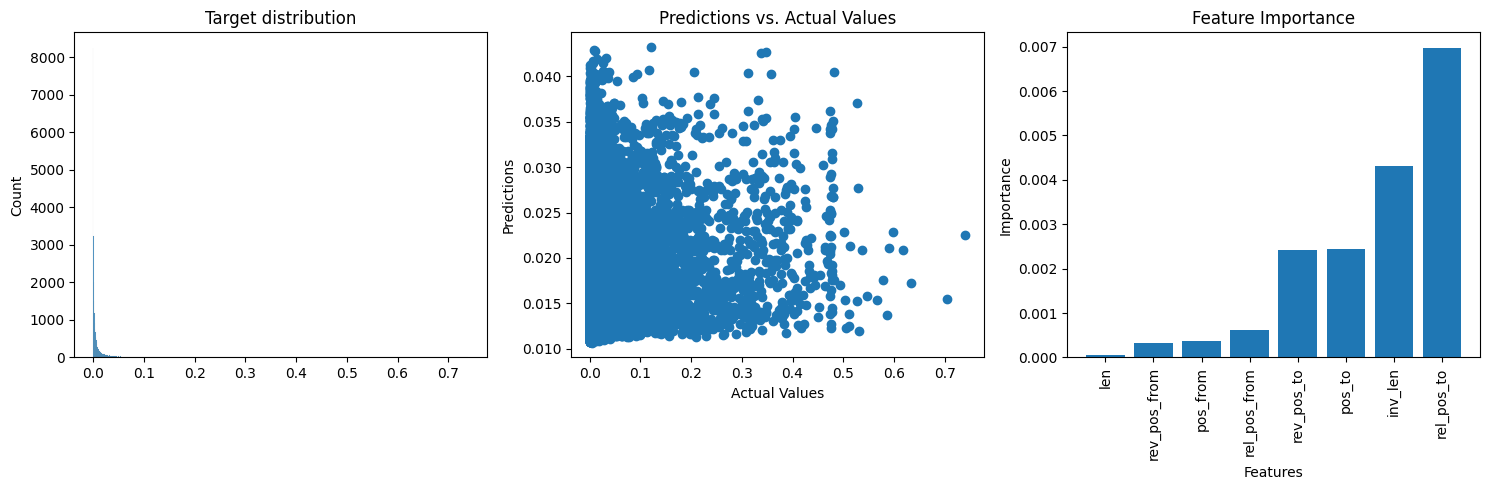

Success


In [28]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO EMB

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.1975666579576802
Test R2: 0.20908722239546407

Predictions:
Pred = 0.009613383638659757 / 0.009613383638659757 and target = 0.038838941603899 / 0.038838941603899


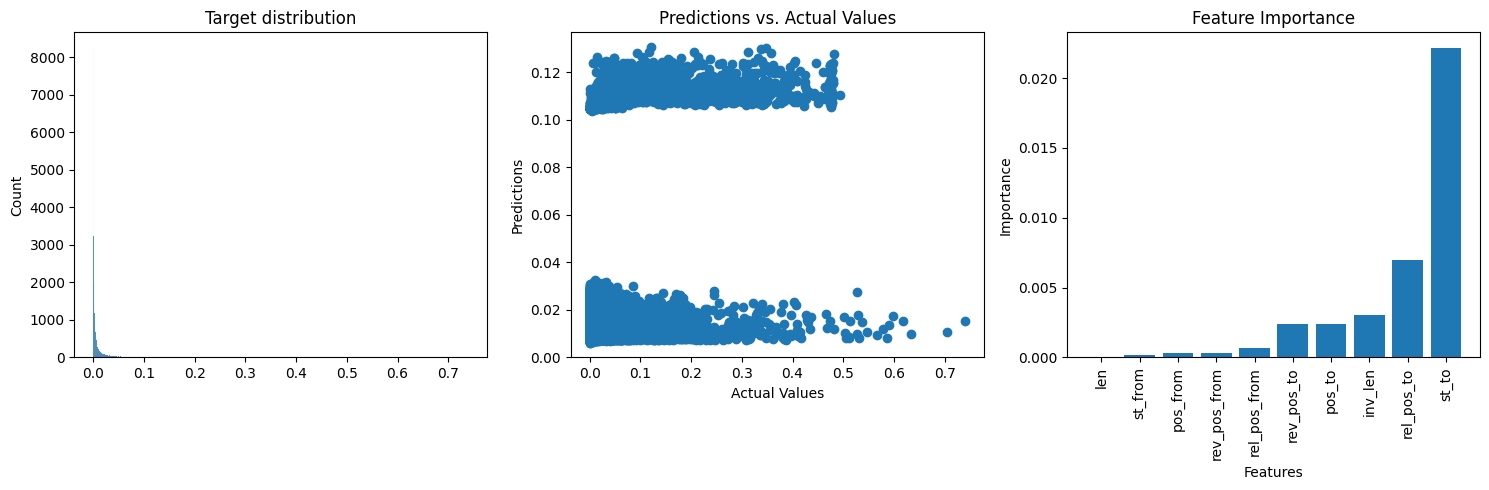

Success


In [29]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ADD POLYNOMIAL

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.1043432750229398
Test R2: 0.11329990414955982

Predictions:
Pred = 0.04642347593601155 / 0.04642347593601155 and target = 0.01993994228541851 / 0.01993994228541851


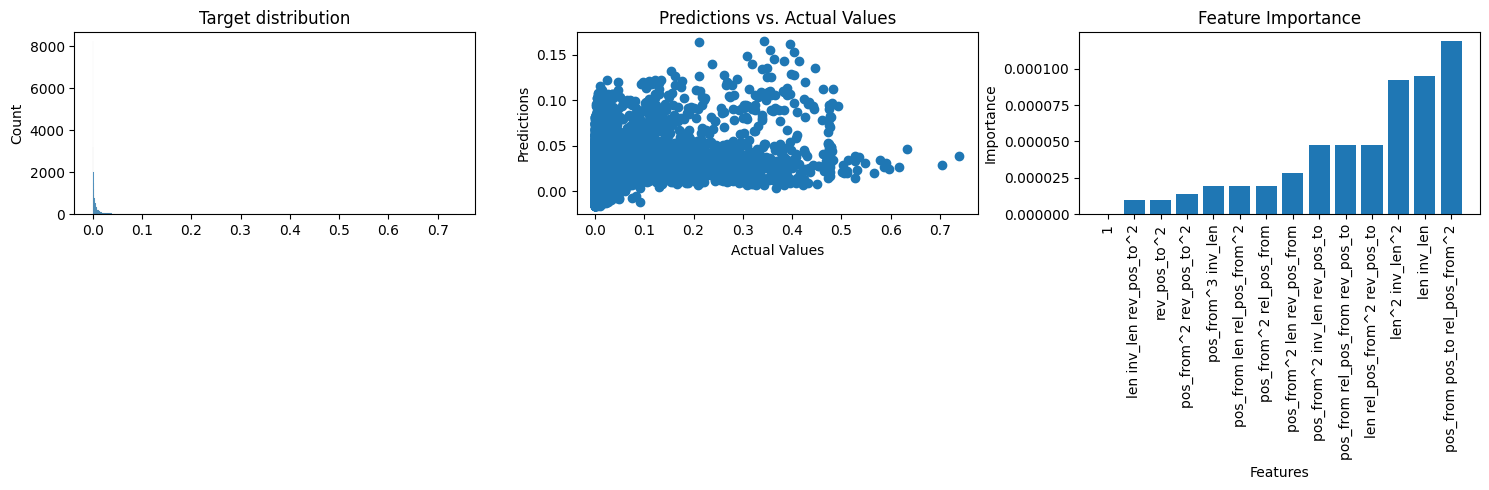

Success


In [30]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

### ADD ALL TOGETHER

Y train mean: 0.017816298
Y test mean: 0.01819301
Mean cross val R2: 0.40115488935221977
Test R2: 0.4119239599128194

Predictions:
Pred = 0.022309365174551378 / 0.022309365174551378 and target = 0.0010995935881510377 / 0.0010995935881510377


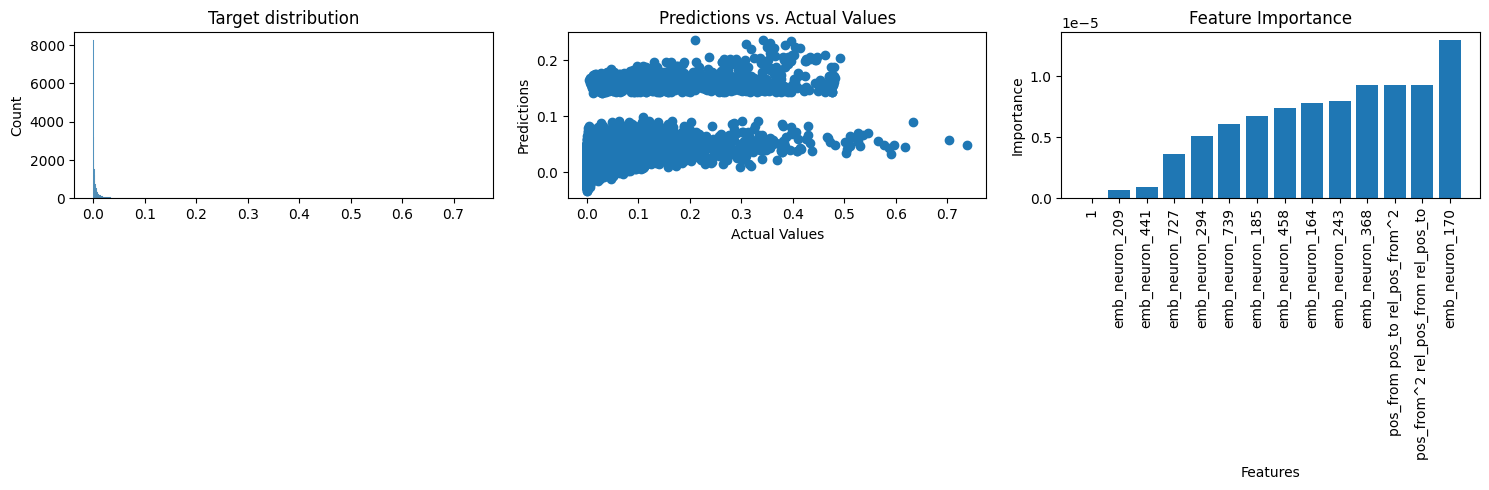

Success


In [31]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

## Layer 11

In [32]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=11, head_num=0)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train.shape, X_test.shape

500it [01:19,  6.31it/s]


((166889, 778), (29209, 778))

### WITH SPECIAL SYMBOLS

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.8264761043867834
Test R2: 0.8411264248575427

Predictions:
Pred = -0.009879721793526766 / -0.009879721793526766 and target = 0.0003567557141650468 / 0.0003567557141650468


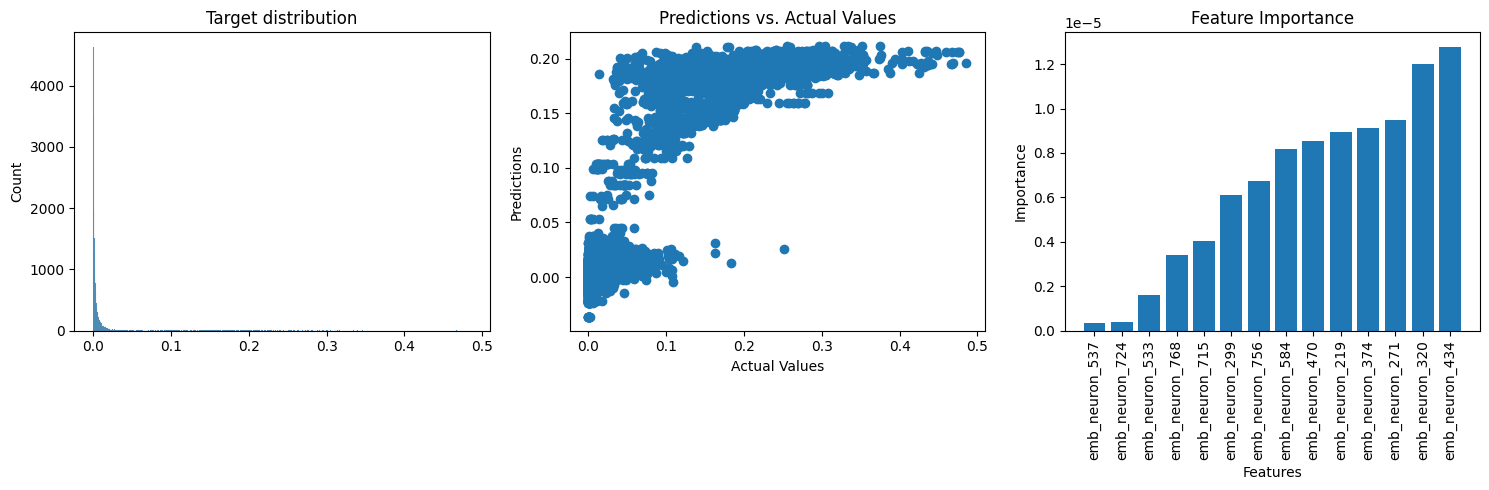

Success


In [33]:

feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.8240481687665275
Test R2: 0.8342614379190731

Predictions:
Pred = 0.003085259055351071 / 0.003085259055351071 and target = 0.0028471495024859905 / 0.0028471495024859905


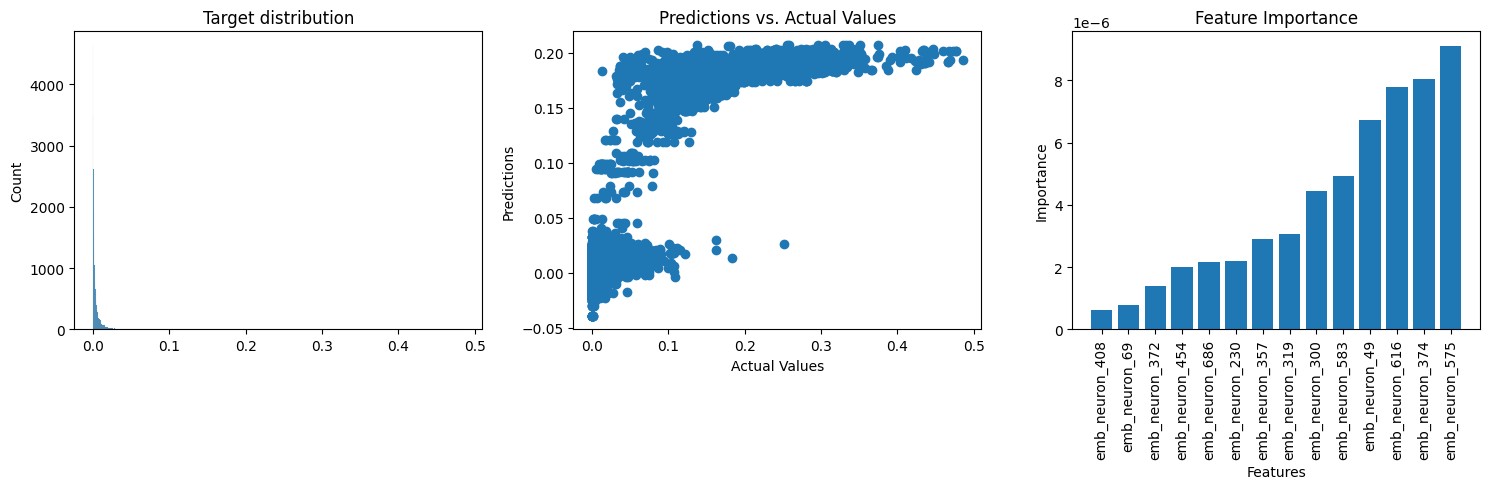

Success


In [34]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO SPECIAL SYMBOLS AND EMB

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.02940918907379648
Test R2: 0.037803478606345475

Predictions:
Pred = 0.014308920179310845 / 0.014308920179310845 and target = 7.653323700651526e-05 / 7.653323700651526e-05


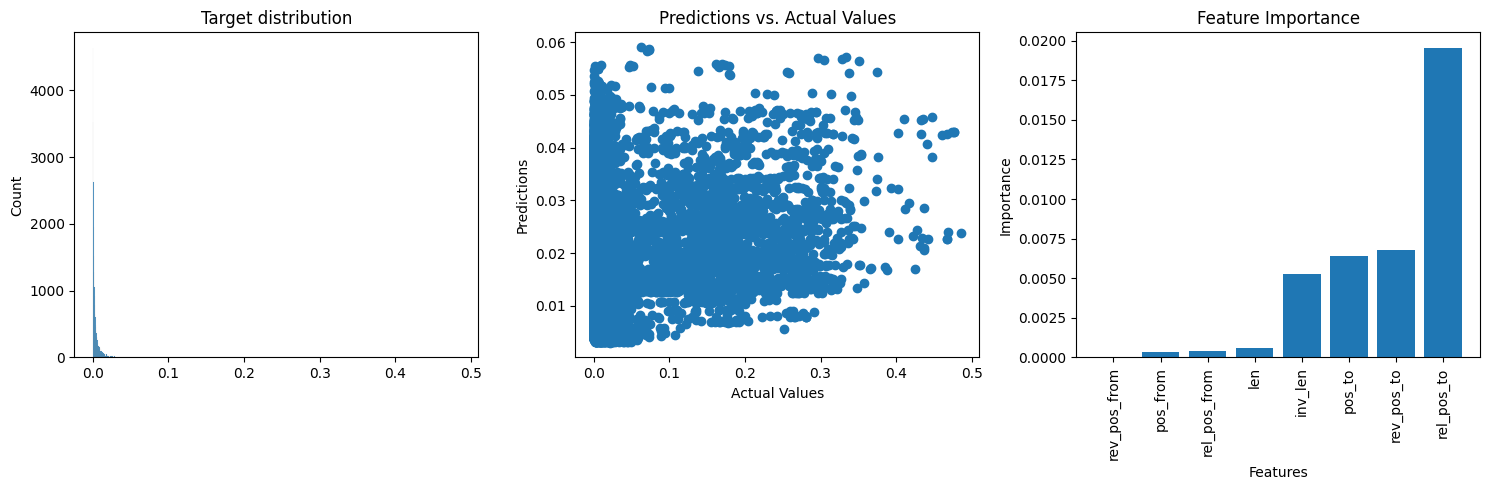

Success


In [35]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### WO EMB

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.051698222903504586
Test R2: 0.0717119437609991

Predictions:
Pred = 0.01642952299591195 / 0.01642952299591195 and target = 0.0022558358032256365 / 0.0022558358032256365


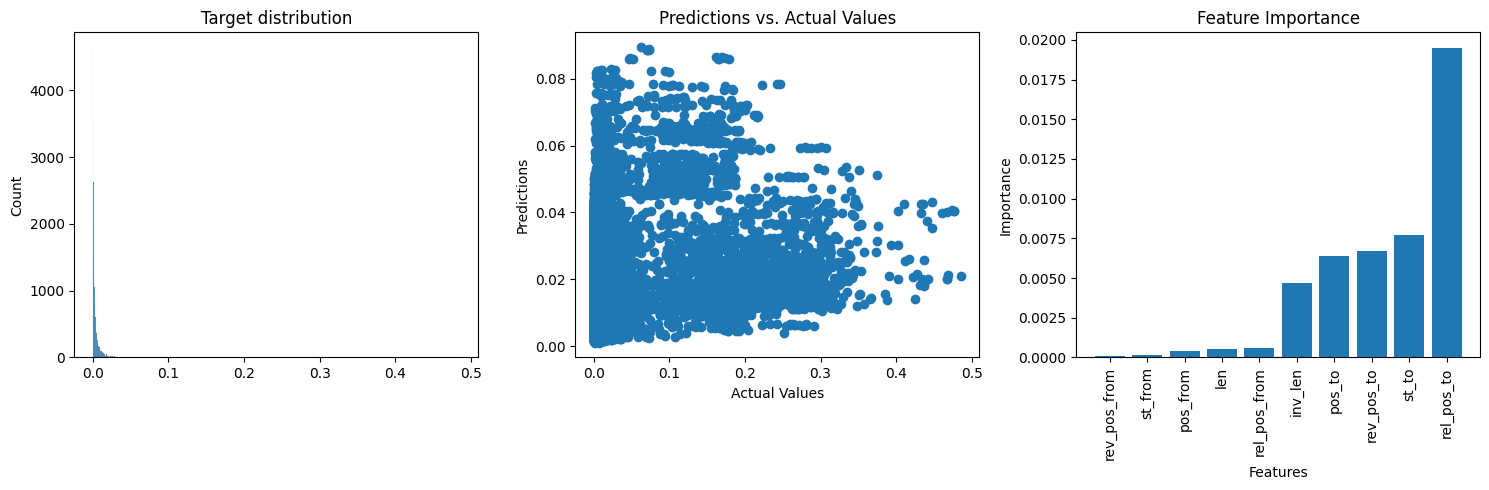

Success


In [36]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ADD POLYNOMIAL

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.14173627633996125
Test R2: 0.14303162478078357

Predictions:
Pred = 0.010970536379193239 / 0.010970536379193239 and target = 0.0007337636197917163 / 0.0007337636197917163


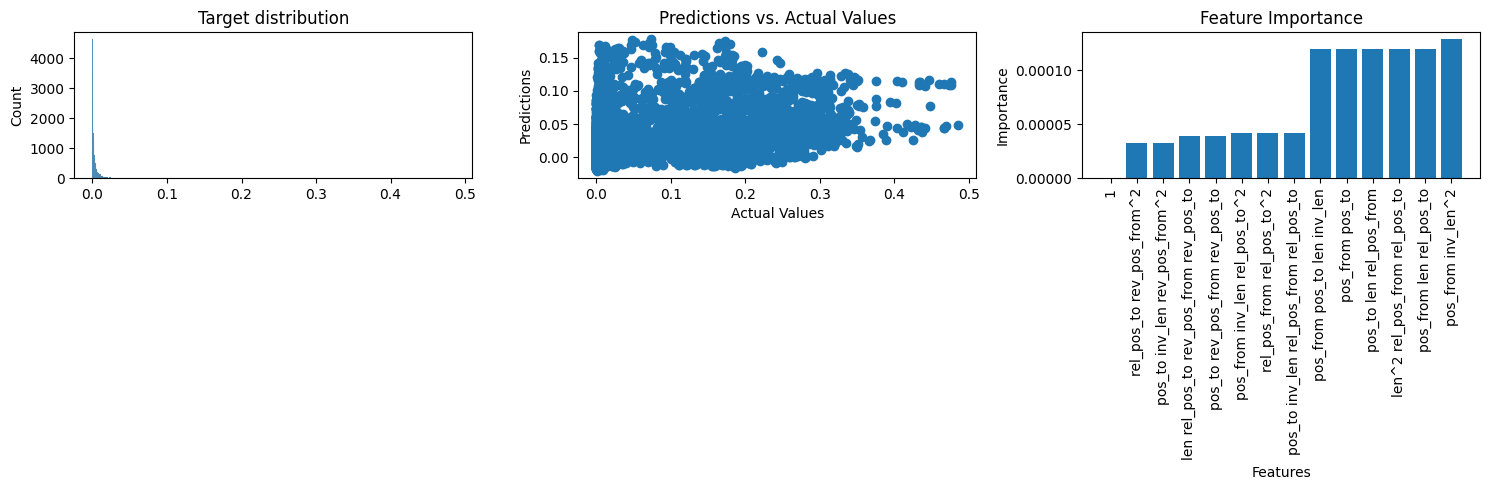

Success


In [37]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

### ADD ALL TOGETHER

Y train mean: 0.017562788
Y test mean: 0.017689567
Mean cross val R2: 0.82610256256556
Test R2: 0.8326832755996809

Predictions:
Pred = 0.006942751928815546 / 0.006942751928815546 and target = 7.455353625118732e-05 / 7.455353625118732e-05


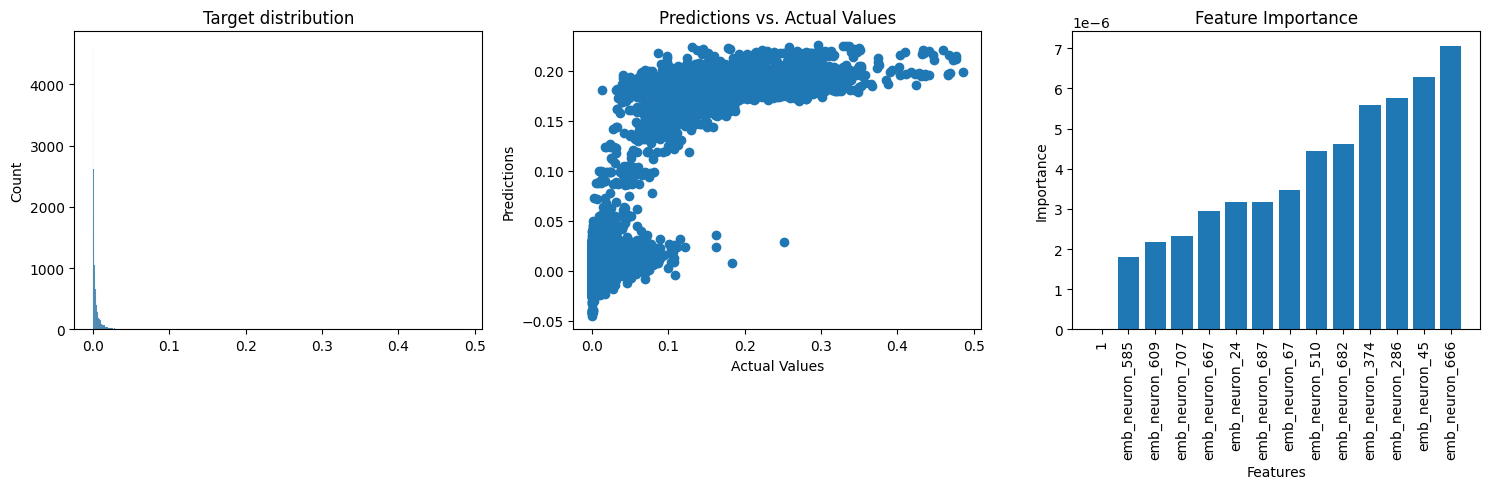

Success


In [38]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))

poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])

X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)

feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]

learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [39]:
X_train_poly.shape

(166889, 1263)